# Data quality assessment

___

In the following we will use the existing data to investigate the data quality and comparability between different images of e.g. the same patient or the same timepoint. To this end, we will conduct the following analysis:

1. Visualization of the data set using tSNE
2. Plotting the distribution of important features describing the nuclear intensity distribution of the different channels.
3. Perform a discriminability analysis using a simple RandomForest classifier to quantify the level of the observed differences.

---

## 0. Evironmental setup

In [58]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

sys.path.append("../../../")

from src.utils.notebooks.eda import *

seed = 1234

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data

After setting up the environment by loading the required packages and functions we will now load in the data set of all available patients and healthy volunteers.

In [59]:
hv_root_data_dir = "../../../data/pbmc_hv/proteins/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [60]:
hv_data = read_in_protein_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 10/10 [00:00<00:00, 42.00it/s]


<IPython.core.display.Javascript object>

In [61]:
tp1_root_data_dir = "../../../data/pbmc_pt/proteins/timepoint_1/"
tp2_root_data_dir = "../../../data/pbmc_pt/proteins/timepoint_2/"
tp3_root_data_dir = "../../../data/pbmc_pt/proteins/timepoint_3/"

tp1_features = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)

tp2_features = read_in_protein_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)

tp3_features = read_in_protein_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)

cancer_data = tp1_features.append(tp2_features).append(tp3_features)
cancer_data["id"] = cancer_data["sample"] + cancer_data["timepoint"]

data = hv_data.append(cancer_data)

Load data: 100%|██████████| 12/12 [00:00<00:00, 36.01it/s]


<IPython.core.display.Javascript object>

In [62]:
print("No. nuclei from healthy volunteers:", len(hv_data))
print("No. nuclei from cancer patients:", len(cancer_data))
print("No. patients:", len(np.unique(cancer_data.loc[:, "sample"])))

No. nuclei from healthy volunteers: 2531
No. nuclei from cancer patients: 19656
No. patients: 15


<IPython.core.display.Javascript object>

After removing nuclei that were not fully captured we obtain 2'531 nuclei from the 10 healthy volunteers and 19'656 from 15 different patient for 1-3 time points each. The histogram below shows the number of nuclei that we have for each unique biological sample (i.e. a unique combination of the patient or healthy volunteer and the timepoint of drawing). On average there are 426.7 ($\pm 184.2$) nuclei per sample. The exact number ranges from 182 to 1024.
Note that we have substantially more nuclei for each cancer patient (468 $\pm$ 180.6) than for each healthy volunteer (253.1 $\pm$ 47.1).

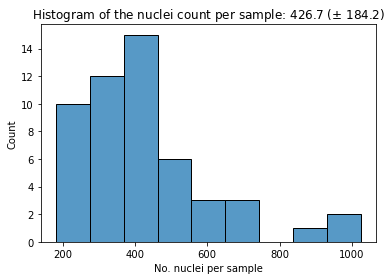

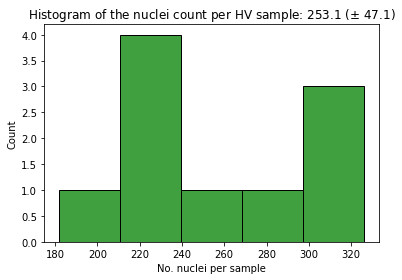

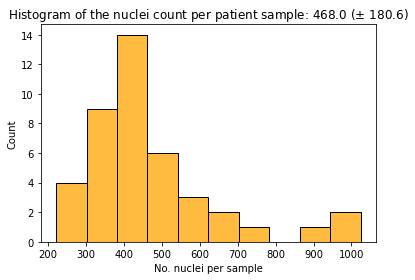

<IPython.core.display.Javascript object>

In [63]:
ax = sns.histplot(list(Counter(data.id).values()))
ax.set_xlabel("No. nuclei per sample")
ax.set_title(
    "Histogram of the nuclei count per sample: {:.1f} ($\pm$ {:.1f})".format(
        np.mean(list(Counter(data.id).values())),
        np.std(list(Counter(data.id).values())),
    )
)
plt.show()

ax = sns.histplot(list(Counter(hv_data.id).values()), color="green")
ax.set_xlabel("No. nuclei per sample")
ax.set_title(
    "Histogram of the nuclei count per HV sample: {:.1f} ($\pm$ {:.1f})".format(
        np.mean(list(Counter(hv_data.id).values())),
        np.std(list(Counter(hv_data.id).values())),
    )
)
plt.show()

ax = sns.histplot(list(Counter(cancer_data.id).values()), color="orange")
ax.set_xlabel("No. nuclei per sample")
ax.set_title(
    "Histogram of the nuclei count per patient sample: {:.1f} ($\pm$ {:.1f})".format(
        np.mean(list(Counter(cancer_data.id).values())),
        np.std(list(Counter(cancer_data.id).values())),
    )
)
plt.show()

In [64]:
Counter(cancer_data.loc[:, "sample"])

Counter({'p20': 1013,
         'p17': 1133,
         'p13': 950,
         'p25': 1736,
         'p15': 1924,
         'p18': 1931,
         'p16': 1277,
         'p19': 742,
         'p21': 1219,
         'p11': 812,
         'p22': 1794,
         'p14': 1287,
         'p12': 984,
         'p29': 1443,
         'p24': 1411})

<IPython.core.display.Javascript object>

---

## 2. Quality assessment

### 2.1. Comparability assessment 

To assess if there are any undesired batch effects between the different samples, we will first look at a number of descriptive statistics for the intensity distribution for each channel for each sample. Note that the differences of those features between different samples should be limited to ensure the comparability of the data. This holds true in particular for the DNA staining but should also be the case for the healthy control data.

The features we will look at are the minimum, maximum and mean intensity of the respective channel in 3D.

#### DNA channel

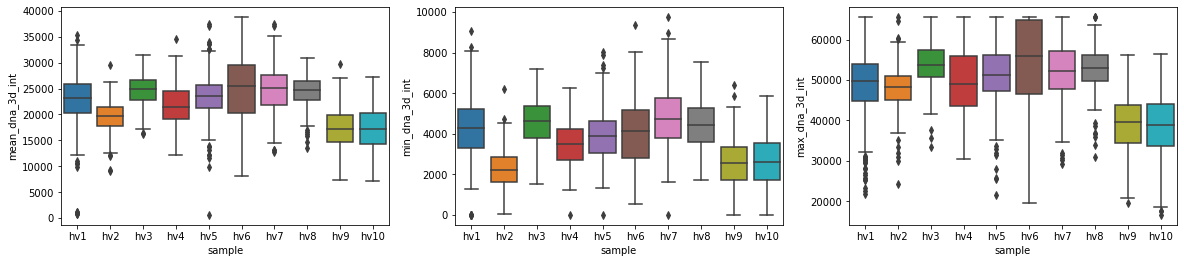

<IPython.core.display.Javascript object>

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="mean_dna_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[0],
)
ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="min_dna_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[1],
)
ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="max_dna_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[2],
)

The above boxplots do not show any strong batch effects although the distribution of the DNA intensity for HV9 and HV10 seems to be shifted significantly to the left compared to the other control samples.

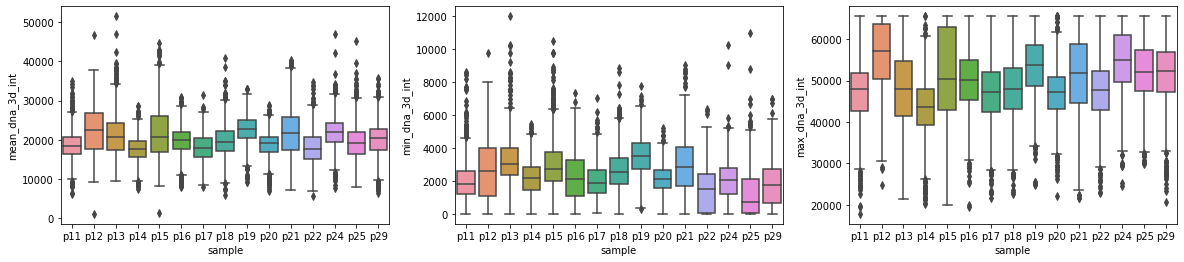

<IPython.core.display.Javascript object>

In [66]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="mean_dna_3d_int",
    ax=ax[0],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="min_dna_3d_int",
    ax=ax[1],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="max_dna_3d_int",
    ax=ax[2],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)

The distribution of the DNA intensity in the nucleus seems to fairly comparable across cancer patients.

---

#### gH2AX channel

In [67]:
from statannot import add_stat_annotation

list(hv_data.columns)

['label',
 'min_calliper',
 'max_calliper',
 'smallest_largest_calliper',
 'min_radius',
 'max_radius',
 'med_radius',
 'avg_radius',
 'mode_radius',
 'd25_radius',
 'd75_radius',
 'std_radius',
 'feret_max',
 'centroid-0',
 'centroid-1',
 'area',
 'perimeter',
 'bbox_area',
 'convex_area',
 'equivalent_diameter',
 'major_axis_length',
 'minor_axis_length',
 'eccentricity',
 'orientation',
 'concavity',
 'solidity',
 'a_r',
 'shape_factor',
 'area_bbarea',
 'avg_curvature',
 'std_curvature',
 'npolarity_changes',
 'max_posi_curv',
 'avg_posi_curv',
 'med_posi_curv',
 'std_posi_curv',
 'sum_posi_curv',
 'len_posi_curv',
 'max_neg_curv',
 'avg_neg_curv',
 'med_neg_curv',
 'std_neg_curv',
 'sum_neg_curv',
 'len_neg_curv',
 'num_prominant_pos_curv',
 'prominance_prominant_pos_curv',
 'width_prominant_pos_curv',
 'prominant_pos_curv',
 'num_prominant_neg_curv',
 'prominance_prominant_neg_curv',
 'width_prominant_neg_curv',
 'prominant_neg_curv',
 'frac_peri_w_posi_curvature',
 'frac_peri_w_

<IPython.core.display.Javascript object>

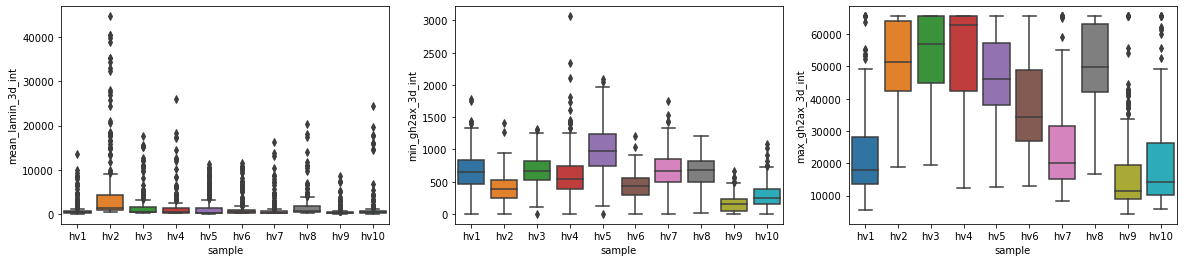

<IPython.core.display.Javascript object>

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="mean_lamin_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[0],
)

ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="min_gh2ax_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[1],
)
ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="max_gh2ax_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[2],
)

The above boxplots indicate that the shift that we observed for DNA intensity for sample 9 and 10 is also visible in the gH2AX channel.

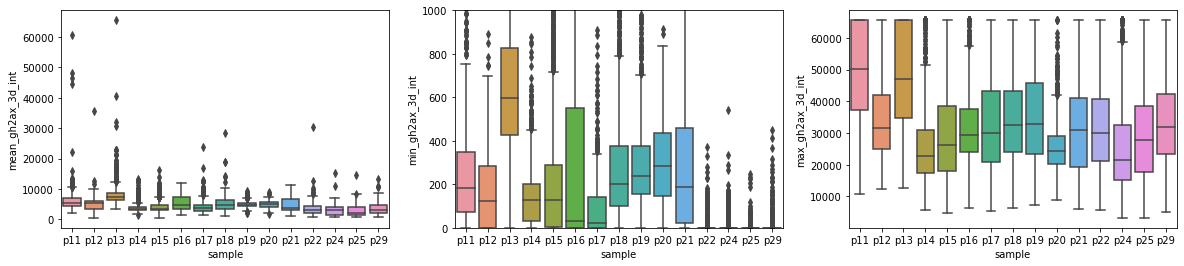

<IPython.core.display.Javascript object>

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="mean_gh2ax_3d_int",
    ax=ax[0],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="min_gh2ax_3d_int",
    ax=ax[1],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[1].set_ylim([0, 1000])
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="max_gh2ax_3d_int",
    ax=ax[2],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)

The distribution of the gH2AX intensity in the nucleus seems to fairly comparable across cancer patients with the first two patients that were imaged P11 and P13 showing a slight shift in the overall intensity distribution to the right. More importantly, we however see that the minimum intensity of gH2AX is significantly lower for the samples P22, P24, P25 and P29.

---

#### Lamin A/C channel

(0.0, 12000.0)

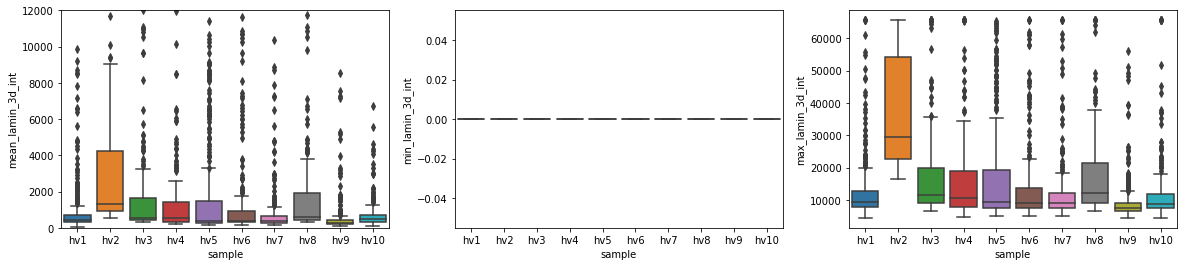

<IPython.core.display.Javascript object>

In [80]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="mean_lamin_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[0],
)
ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="min_lamin_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[1],
)
ax[1] = sns.boxplot(
    data=hv_data,
    x="sample",
    y="max_lamin_3d_int",
    order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[2],
)
ax[0].set_ylim([0, 12000])

The above boxplots indicate that HV2 seems to be an outlier with a significantly more heterogenous lamin staining in the nucleus which is on average also significantly higher than for the other samples.

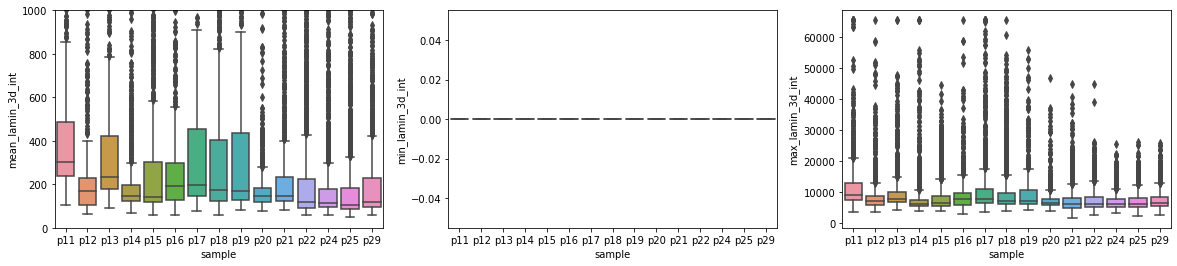

<IPython.core.display.Javascript object>

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=[20, 4])
ax = ax.flatten()

ax[0] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="mean_lamin_3d_int",
    ax=ax[0],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[0].set_ylim([0, 1000])
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="min_lamin_3d_int",
    ax=ax[1],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)
ax[1] = sns.boxplot(
    data=cancer_data,
    x="sample",
    y="max_lamin_3d_int",
    ax=ax[2],
    order=sorted(np.unique(cancer_data.loc[:, "sample"])),
)

The distribution of the Lamin A/C intensity in the nucleus seems to fairly comparable across cancer patients.

---

### 2.2. Visualization of the data sets

Next, we will visually look for batch effects by plotting the data in 2D using tSNE for dimensionality reduction after removing all features that are correlated with a Pearson correlation of above 0.8. We also remove all nuclei for which some of the features could not be measured and further remove constant features.

In [82]:
data = preprocess_data(data)

Nuclei that did not pass the quality check: 1158/22187. Remaining: 21029.
Removed 37 constant or features with missing values. Remaining: 262.
Removed additional 6 features. Remaining: 256.


<IPython.core.display.Javascript object>

In [83]:
features = data._get_numeric_data()
sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]
id_labels = data.loc[:, "id"]

<IPython.core.display.Javascript object>

In [84]:
features = remove_correlated_features(features, threshold=0.8)

Removed 184/253 features with a Pearson correlation above 0.8. Remaining: 69


<IPython.core.display.Javascript object>

Those preprocessing steps remove 1'158 nuclei and 227 features. We now normalize the data and compute the tSNE plots for the control and cancer population individually first to look for batch effects.

In [85]:
features_sc = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)

<IPython.core.display.Javascript object>

For comparison reasons, we will also just look at the chromatin features and manually filter out all features related to Lamin A/C and gH2AX and DNA.

In [102]:
chrometrics = features[features.columns.drop(list(features.filter(regex="gh2ax")))]
chrometrics = chrometrics[
    chrometrics.columns.drop(list(chrometrics.filter(regex="lamin")))
]
chrometrics = chrometrics[
    chrometrics.columns.drop(list(chrometrics.filter(regex="dna")))
]

<IPython.core.display.Javascript object>

In [103]:
chrometrics_sc = pd.DataFrame(
    StandardScaler().fit_transform(chrometrics),
    index=chrometrics.index,
    columns=chrometrics.columns,
)

<IPython.core.display.Javascript object>

---

#### Control population

In [104]:
hv_features_sc = features_sc.loc[tp_labels.loc[tp_labels == "ctrl"].index]
hv_chrometrics_sc = chrometrics_sc.loc[tp_labels.loc[tp_labels == "ctrl"].index]

<IPython.core.display.Javascript object>

In [105]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(hv_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=hv_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])

chrometrics_embs = tsne.fit_transform(hv_chrometrics_sc)
chrometrics_embs = pd.DataFrame(
    chrometrics_embs, columns=["tsne_0", "tsne_1"], index=hv_chrometrics_sc.index
)
chrometrics_embs.loc[:, "sample"] = np.array(data.loc[chrometrics_embs.index, "sample"])
chrometrics_embs.loc[:, "timepoint"] = np.array(
    data.loc[chrometrics_embs.index, "timepoint"]
)

<IPython.core.display.Javascript object>

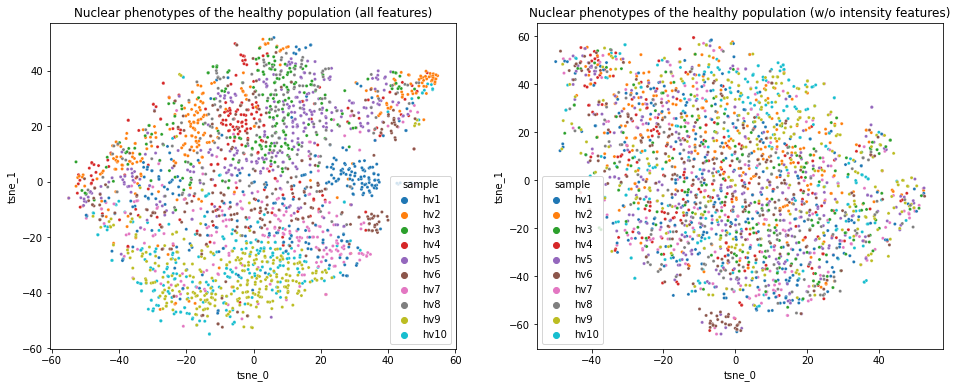

<IPython.core.display.Javascript object>

In [108]:
fig, ax = plt.subplots(figsize=[16, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    s=10,
    hue_order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[0],
)
ax[0].set_title("Nuclear phenotypes of the healthy population (all features)")

ax[1] = sns.scatterplot(
    data=chrometrics_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    s=10,
    hue_order=[
        "hv{}".format(i + 1) for i in range(len(np.unique(hv_data.loc[:, "sample"])))
    ],
    ax=ax[1],
)
ax[1].set_title("Nuclear phenotypes of the healthy population (w/o intensity features)")
plt.show()

While the plot above does not indicate any strong batch effects, we can nonetheless see the samples of HV9 and HV10 grouping together while the remaining samples are better mixed. This can be explained by the shift in the intensity distributions that we described earlier for those two samples.

---



#### Patient population

In [109]:
pt_features_sc = features_sc.loc[tp_labels.loc[tp_labels != "ctrl"].index]
pt_chrometrics_sc = chrometrics_sc.loc[tp_labels.loc[tp_labels != "ctrl"].index]

<IPython.core.display.Javascript object>

In [110]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(pt_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=pt_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])

chrometrics_embs = tsne.fit_transform(pt_chrometrics_sc)
chrometrics_embs = pd.DataFrame(
    chrometrics_embs, columns=["tsne_0", "tsne_1"], index=pt_chrometrics_sc.index
)
chrometrics_embs.loc[:, "sample"] = np.array(data.loc[chrometrics_embs.index, "sample"])
chrometrics_embs.loc[:, "timepoint"] = np.array(
    data.loc[chrometrics_embs.index, "timepoint"]
)

<IPython.core.display.Javascript object>

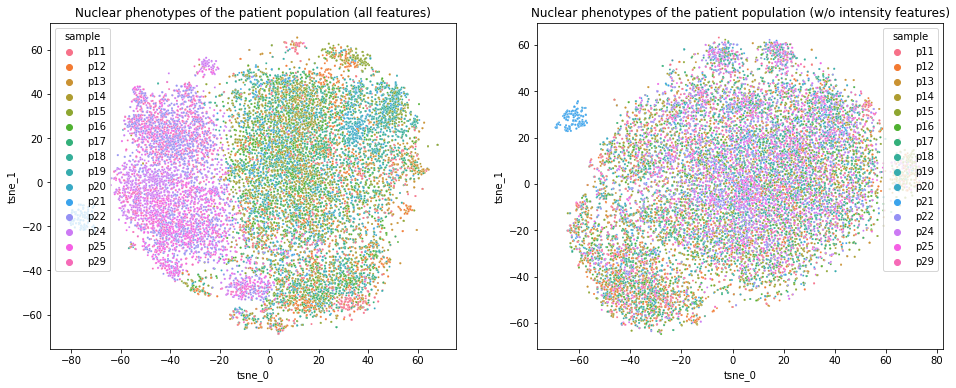

<IPython.core.display.Javascript object>

In [118]:
fig, ax = plt.subplots(figsize=[16, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    s=4,
    ax=ax[0],
    hue_order=sorted(np.unique(tsne_embs.loc[:, "sample"])),
)
ax[0].set_title("Nuclear phenotypes of the patient population (all features)")

ax[1] = sns.scatterplot(
    data=chrometrics_embs,
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    s=4,
    ax=ax[1],
    hue_order=sorted(np.unique(tsne_embs.loc[:, "sample"])),
)
ax[1].set_title("Nuclear phenotypes of the patient population (w/o intensity features)")
plt.show()

We see more structure for the cancer patient nuclei however again no clear separated clusters. However, P29 seems feature slightly different nuclear phenotypes compared to the rest of the patients. However, since the patient distribution is heterogeneous in terms of cancer types, preceding treatment and measured timepoints. This is expected.

---



### 2.3. Discriminability analyses

Next, we will assess the heterogeneity of the different samples by evaluating the performance of a RandomForest classifier in a 10-fold stratified cross-validation scheme to distinguish between the different samples.

#### Control population

In [136]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=5,
    features=hv_features_sc,
    labels=sample_labels.loc[hv_features_sc.index],
)

rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
chrom_avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=5,
    features=hv_chrometrics_sc,
    labels=sample_labels.loc[hv_chrometrics_sc.index],
)

<IPython.core.display.Javascript object>

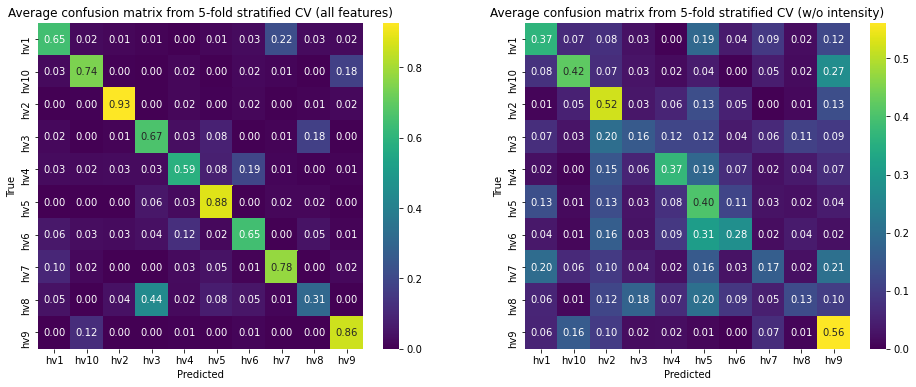

<IPython.core.display.Javascript object>

In [137]:
fig, ax = plt.subplots(figsize=[16, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax[0], fmt=".2f")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_title(
    "Average confusion matrix from {}-fold stratified CV (all features)".format(5)
)
ax[1] = sns.heatmap(chrom_avg_conf_mtx, annot=True, cmap="viridis", ax=ax[1], fmt=".2f")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_title(
    "Average confusion matrix from {}-fold stratified CV (w/o intensity)".format(5)
)
plt.show()

We see that the classifier can distinguish the samples relatively well but especially sample HV2, HV5 and HV9 seem to feature distinct nuclear phenotypes as the classifier performs extremely well on those.

---

#### Patient population

In [119]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=5,
    features=pt_features_sc,
    labels=sample_labels.loc[pt_features_sc.index],
)

rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
chrom_avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=5,
    features=pt_chrometrics_sc,
    labels=sample_labels.loc[pt_chrometrics_sc.index],
)

<IPython.core.display.Javascript object>

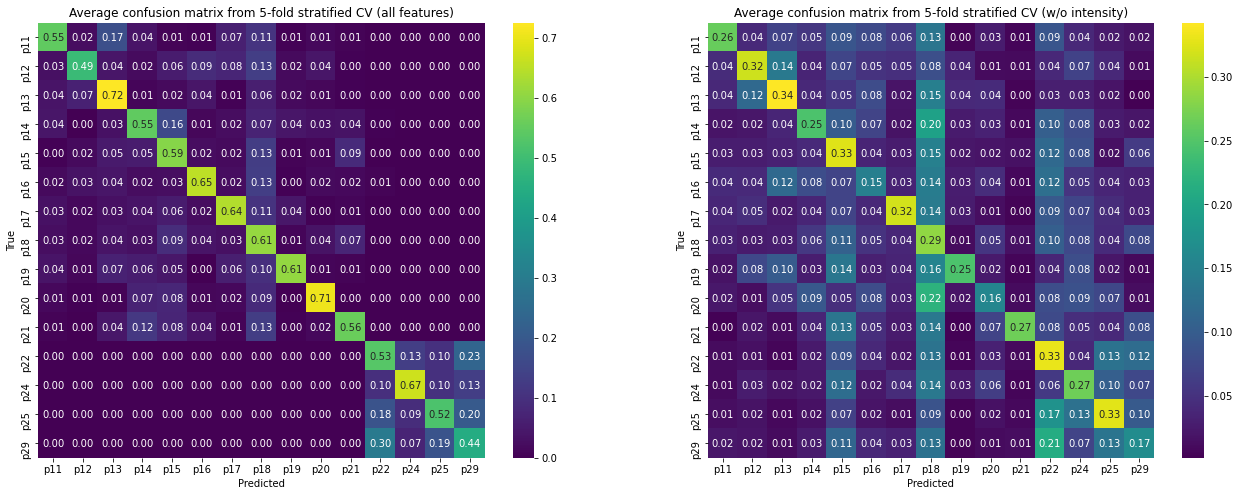

<IPython.core.display.Javascript object>

In [128]:
fig, ax = plt.subplots(figsize=[22, 8], ncols=2)
ax = ax.flatten()
ax[0] = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax[0], fmt=".2f")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_title(
    "Average confusion matrix from {}-fold stratified CV (all features)".format(5)
)
ax[1] = sns.heatmap(chrom_avg_conf_mtx, annot=True, cmap="viridis", ax=ax[1], fmt=".2f")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_title(
    "Average confusion matrix from {}-fold stratified CV (w/o intensity)".format(5)
)
plt.show()

In [135]:
Counter(cancer_data.loc[:, "sample"])

Counter({'p20': 1013,
         'p17': 1133,
         'p13': 950,
         'p25': 1736,
         'p15': 1924,
         'p18': 1931,
         'p16': 1277,
         'p19': 742,
         'p21': 1219,
         'p11': 812,
         'p22': 1794,
         'p14': 1287,
         'p12': 984,
         'p29': 1443,
         'p24': 1411})

<IPython.core.display.Javascript object>

It seems as if there is a batch effect that separates P22, P24, P25 and P29 from the rest. The cause for that needs to be investigated.

In [124]:
group_labels = np.repeat("Functional1", len(pt_chrometrics_sc))
for i in tqdm(range(len(group_labels))):
    if np.array(sample_labels.loc[pt_chrometrics_sc.index])[i] in [
        "p22",
        "p24",
        "p25",
        "p29",
    ]:
        group_labels[i] = "Functional2"

100%|██████████| 18683/18683 [00:51<00:00, 364.75it/s]


<IPython.core.display.Javascript object>

In [125]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x, y = rus.fit_resample(pt_chrometrics_sc, group_labels)
x = pd.DataFrame(x, columns=pt_chrometrics_sc.columns)

<IPython.core.display.Javascript object>

In [126]:
len(x)

11872

<IPython.core.display.Javascript object>

In [127]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
chrom_2_avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=5,
    features=x,
    labels=y,
)

<IPython.core.display.Javascript object>

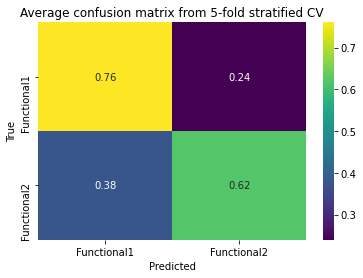

<IPython.core.display.Javascript object>

In [130]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.heatmap(chrom_2_avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(5))
plt.show()

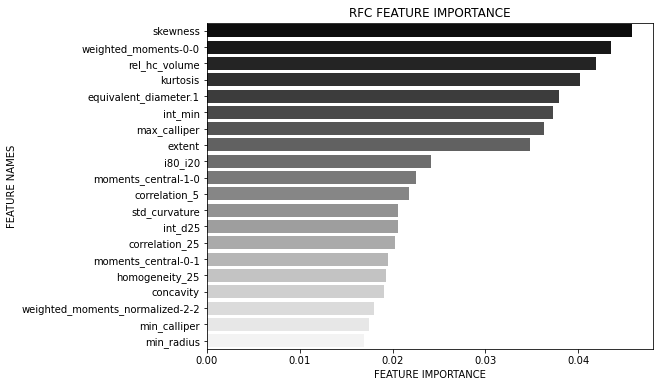

<IPython.core.display.Javascript object>

In [131]:
rfc = rfc.fit(x, y)
plot_feature_importance(rfc.feature_importances_, x.columns, "RFC ")